In [82]:
using PyCall
using Statistics
using LinearAlgebra
using Random
using Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using JLD2
#using OptimKit
;

In [83]:
# PyCallを用いてPythonのライブラリをインポート
np = pyimport("numpy")
@pyimport tf_quant_finance as tff
@pyimport tensorflow 

In [101]:
# オプション満期
T = 1.0
# 無リスク金利
r = 0.01
# strike
K = 100.0
# 原資産数
d = 5
# 原資産価格初期値
#S0 = [100.0] * d

#l(0.5, d)
# 相関行列


corrMat = Matrix{Float64}(I, d, d)
for i in 1:d
    for j in 1:d
        if i != j
            corrMat[i, j] = 1/2
        end
    end
end



#localindex_v = [51 for _ in 1:d]
#localindex_v  =  [69, 13, 91, 87, 51]
#localindex_v = [79, 66, 54, 76, 62] # const 0.5 
#ocalindex_v = [74, 86, 70, 54, 68] # const 0.5 with noisy
localindex_v = [72, 74, 86, 63, 79] # const 0.5 
nPath = 1000000
S0 = fill(100, d)

# パス数
#nPath = 10000000
σs = collect(0.15:0.001:0.249)
stock0 = collect(90.0:0.3:119.7)
;

In [102]:
corrMat

5×5 Matrix{Float64}:
 1.0  0.5  0.5  0.5  0.5
 0.5  1.0  0.5  0.5  0.5
 0.5  0.5  1.0  0.5  0.5
 0.5  0.5  0.5  1.0  0.5
 0.5  0.5  0.5  0.5  1.0

In [103]:
#=
corrMat = [ 
    1.0       0.014664  0.10966   0.437896   0.133544 ;
    0.014664  1.0       0.48206   0.585829   0.576213 ;
    0.10966   0.48206   1.0       0.607172   0.524112 ;
    0.437896  0.585829  0.607172  1.0        0.0560393 ;
    0.133544  0.576213  0.524112  0.0560393  1.0]

=#


#=
corrMat = [
    1.0       0.303659  0.505532  0.719655  0.728832;
 0.303659  1.0       0.401077  0.515272  0.178203;
 0.505532  0.401077  1.0       0.132542  0.722767;
 0.719655  0.515272  0.132542  1.0       0.394723;
 0.728832  0.178203  0.722767  0.394723  1.0]
 
=#

#=
corrMat = [ 1.0       0.472591  0.595334  0.453276  0.554031;
    0.472591  1.0       0.42697   0.539885  0.533166;
    0.595334  0.42697   1.0       0.531799  0.462572;
    0.453276  0.539885  0.531799  1.0       0.593003;
    0.554031  0.533166  0.462572  0.593003  1.0]
=#

In [104]:
is_symmetric(matrix::AbstractMatrix) = matrix == matrix'
is_symmetric(corrMat)

eigvals(corrMat)

5-element Vector{Float64}:
 0.4999999999999994
 0.4999999999999997
 0.49999999999999994
 0.5000000000000001
 2.999999999999999

In [105]:
len = length(σs)

100

In [106]:
function calculate_option_price(T::Float64, r::Float64, K::Float64, d::Int64, S0::Vector{Int64}, stock0::Vector{Float64}, localindex_v::Vector{Int64}, nPath::Int64, σs::Vector{Float64}, corrMat)::Tuple{Float64, Float64}
    vols = [σs[i] for i in localindex_v[1:d]]
    #S0s = [stock0[i] for i in localindex_v[d+1:2*d]]

    process = tff.models.MultivariateGeometricBrownianMotion(
        dim=d,
        means=fill(r, d),
        #volatilities=fill(0.2, d),
        volatilities=vols,
        corr_matrix=corrMat)
    
    paths = process.sample_paths(
        times=[T],
        #initial_state=S0s,
        initial_state=S0,
        random_type=tff.math.random.RandomType.PSEUDO,
        num_samples=nPath).numpy()
    
    payoffs = max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0)
    #payoffs = vec(payoffs)  # 配列をベクトルに変換
    mean_pv = exp(-r * T) * mean(payoffs)
    std_pv = exp(-r * T) * std(payoffs)
    #pv = exp(-r * T) * mean(max.(minimum(paths[:, 1, :], dims=2) .- K, 0.0))
    return (mean_pv, std_pv)
    #return pv

end

calculate_option_price (generic function with 1 method)

In [107]:
# オプション価格の計算
mean_pv, std_pv = calculate_option_price(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat)
println("Present Value: ", mean_pv)
println("Standard Deviation: ", std_pv)
#pv = calculate_option_price(T, r, K, d, S0, localindex, nPath, σs, corrMat)
#println(pv)
;

Present Value: 1.524715278468557
Standard Deviation: 5.133718418169587


In [108]:
true_value = 1.3885828365963908
println("真の値: ", true_value)
;

真の値: 1.3885828365963908


In [109]:
SE = std_pv/sqrt(nPath)
CI = 1.96 * std_pv/sqrt(nPath)
#@show 1.96 * SE
#println("絶対誤差の指標の代わり=", 2 * 1.96 * SE) 
println("CI: ", CI) 
#println("Present Value + CI: ", mean_pv + CI) 
#println("Present Value - CI: ", mean_pv - CI) 
#@show mean_pv + CI #　信頼区間
#@show mean_pv - CI # 信頼区間
;

CI: 0.01006208809961239


In [100]:

time_mc = @elapsed begin
    for i in 1:20
        calculate_option_price(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat)
    end
end
time_mc/20


0.0153941625

In [67]:
function generate_random_combinations(len, d, num_samples)
    Random.seed!(100)

    possible_values = collect(1:len)
    random_combinations = Vector{Int}[]
    
    for _ in 1:num_samples
        combination = rand(possible_values, d)
        push!(random_combinations, combination)
    end
    
    return random_combinations
end


# Option pricing taking random combinations of parameters
function rand_inner(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat, len, num_samples, random_combinations)
    #random_combinations = generate_random_combinations(len, d, num_samples)
    #random_combinations = [[i, 2, 2, 2, 2] for i in 1:len]

    results = Vector{ComplexF64}()
    
    for i in 1:num_samples
        ind = random_combinations[i]
        localindex_v = ind
        #inner_ = inner_p(d, ind, M_phi, M_v)
        #result = (( η^d ) * exp(-r * (T - t)) * inner_) / ((2 * π) ^ d)
        result, _ = calculate_option_price(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat)
    
        push!(results, result)
    end
    return results, random_combinations
end

num_samples = 100  # Number of parameter combinations

#random_combinations = generate_random_combinations(len, d, num_samples)
#results, combinations = rand_inner(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat, len, num_samples, random_combinations)
#mc =  real(results)



#=
for j in 1:5
    random_combinations = [[i, j+1, 2, 2, 2] for i in 1:len]
    results, combinations = rand_inner(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat, len, num_samples, random_combinations)
    tt = real(results)
    JLD2.@save "vol_mc_d5_50000000_const_diff_$j.jld2" tt
end
=#

100

In [68]:
#JLD2.@save "stock_mc_d5_50000000_const_0.5_noise.jld2" mc

In [69]:
#=
for j in 1:5
    random_combinations = [[i, j+1, 24, 56, 90] for i in 1:len]
    results, combinations = rand_inner(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat, len, num_samples, random_combinations)
    tt = real(results)
    JLD2.@save "vol_d5_50000000_const_diff_2_$j.jld2" tt
end
=#

In [70]:
#=
random_combinations = [[i, 2, 27, 79, 53] for i in 1:len]
results, combinations = rand_inner(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat, len, num_samples, random_combinations)
tt = real(results)
JLD2.@save "vol_mc_d5_50000000_const_[[i, 2, 27, 79, 53].jld2" tt
=#

In [71]:
random_combinations = [[i, 2, 2, 2, 2] for i in 1:len]
#random_combinations = [[i, 2, 27, 79, 53] for i in 1:len]
results, combinations = rand_inner(T, r, K, d, S0, stock0, localindex_v, nPath, σs, corrMat, len, num_samples, random_combinations)
tt = real(results)
JLD2.@save "vol_mc_d5_50000000_const_[i, 2, 2, 2, 2] .jld2" tt

In [72]:
mc = [real(x) for x in results]
mc

100-element Vector{Float64}:
 1.142700495106409
 1.1431288929634917
 1.144227919563949
 1.1458410815448798
 1.1461701371971895
 1.1479541322891924
 1.148662411287647
 1.1502705469356016
 1.1510123918123913
 1.1524376137432712
 ⋮
 1.191738806553156
 1.1914784125703766
 1.1930671999333518
 1.1928171270693897
 1.1930562934011584
 1.193304133661878
 1.1938629172220658
 1.1933179000550267
 1.1937173713560991

In [73]:
abs.(diff(mc))

99-element Vector{Float64}:
 0.0004283978570827074
 0.0010990266004573535
 0.0016131619809307551
 0.00032905565230967326
 0.001783995092002888
 0.0007082789984544924
 0.0016081356479547004
 0.0007418448767897434
 0.0014252219308799052
 6.818047160228602e-5
 ⋮
 0.0004787160125021561
 0.0002603939827794388
 0.0015887873629751859
 0.00025007286396205863
 0.00023916633176868096
 0.0002478402607195562
 0.0005587835601879032
 0.0005450171670391413
 0.00039947130107242934

In [74]:
JLD2.@save "vol_mc_d5_50000000_const_diff.jld2" mc
JLD2.@load "vol_mc_d5_50000000_const_diff.jld2" mc
mc

100-element Vector{Float64}:
 1.142700495106409
 1.1431288929634917
 1.144227919563949
 1.1458410815448798
 1.1461701371971895
 1.1479541322891924
 1.148662411287647
 1.1502705469356016
 1.1510123918123913
 1.1524376137432712
 ⋮
 1.191738806553156
 1.1914784125703766
 1.1930671999333518
 1.1928171270693897
 1.1930562934011584
 1.193304133661878
 1.1938629172220658
 1.1933179000550267
 1.1937173713560991

In [75]:
abs.(diff(mc)) ./ diff(σs)

99-element Vector{Float64}:
 0.428397857082707
 1.0990266004573526
 1.6131619809307538
 0.329055652309673
 1.7839950920028864
 0.7082789984544917
 1.608135647954699
 0.7418448767897428
 1.425221930879904
 0.06818047160228596
 ⋮
 0.4787160125021557
 0.2603939827794386
 1.5887873629751845
 0.2500728639620584
 0.23916633176868074
 0.247840260719556
 0.5587835601879028
 0.5450171670391408
 0.399471301072429

In [76]:
using Plots


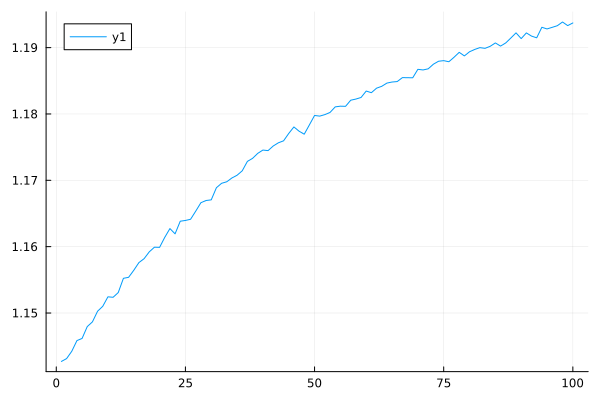

In [77]:
plot(mc)

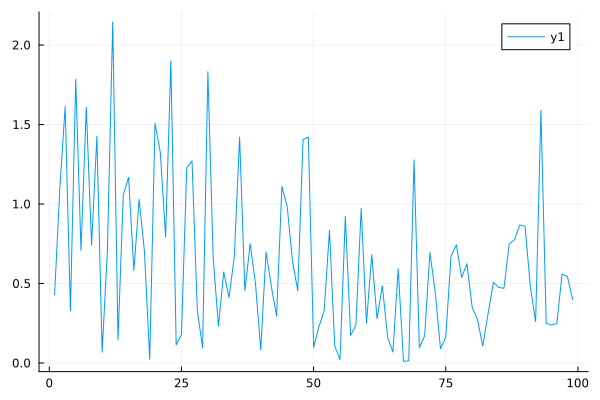

In [78]:
plot(abs.(diff(mc)) ./ diff(σs))

In [79]:
#=
using CSV
using DataFrames
csv_monte = CSV.File("volatility_5e7_d5_015025_100.csv") |> DataFrame   #d=5
monte_d5 = Vector(csv_monte[1,:])
=#

In [80]:
#maximum(mc .- monte_d5)